Описание датасета: датасет сождержит 16231 уникальных строк с данными по вакансиям, а именно:
- название вакансии
- режим работы
- тип занятости
- описание вакансии
- требуемые навыки
- зарплата

цель проекта - построить модель, которая сможет предсказывать зарплату по описанию вакансии. Сам датасет взят из соревнования "2nd step in NLP", которое недавно поводила ВШЭ.
В бейзлайне который был предоставлен организаторами использовался Gensim'овский НЕ-предобученный Word2Vec, который обучили на колонке с описаниями вакансий, получив эмбеддинги для каждого слова и усреднив их, тем самым получив W2V всего описания вакансии. Далее для предсказания запралаты использовали обычую линейную регрессию с L1 регуляризатором. 

Я попробую нсколько подходов, состоящих из комбинации способа получения вектора текста и предсказательной модели:
Получение векторов:
- различные вариации TFIDF
- Word2Vec (дообучение уже обученного gensim), с добавлением векторов других признакв
- Предобученный BERT (DeepPavlov/rubert-basecased и cointegrated/rubert-tiny2)

Предсказательная модель:
- L1 / L2 регресии
- Опорные вектора
- Простенькая fully-connected нейронка

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)



In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 8]


import random
random.seed(1337)
np.random.seed(1337)
rng = 1337

In [5]:
df = pd.read_csv('vacancies_train.csv')

In [6]:
df.head(3)

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0


In [7]:
df.isna().sum()

name           0
experience     0
schedule       0
employment     0
description    0
key_skills     0
salary         0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16629 entries, 0 to 16628
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         16629 non-null  object 
 1   experience   16629 non-null  object 
 2   schedule     16629 non-null  object 
 3   employment   16629 non-null  object 
 4   description  16629 non-null  object 
 5   key_skills   16629 non-null  object 
 6   salary       16629 non-null  float64
dtypes: float64(1), object(6)
memory usage: 909.5+ KB


Пропусков нет, кроме колонки "требуемые навыки", но она нас не так сильно волнует.

In [9]:
# посмотрим есть ли задвоения строк:
df[df.duplicated(keep=False)].sort_values(by='salary')

,name,experience,schedule,employment,description,key_skills,salary
14275,Медицинская сестра,Нет опыта,Полный день,Полная занятость,Работа на территории работодателя: р-н Выселко...,[],12130.0
67,Медицинская сестра,Нет опыта,Полный день,Полная занятость,Работа на территории работодателя: р-н Выселко...,[],12130.0
8612,Медицинская сестра,Нет опыта,Полный день,Полная занятость,Работа на территории работодателя: р-н Брюхове...,[],12130.0
16026,Медицинская сестра,Нет опыта,Полный день,Полная занятость,Работа на территории работодателя: р-н Брюхове...,[],12130.0
6430,Врач-косметолог,Нет опыта,Гибкий график,Частичная занятость,Работа на территории работодателя: г Новоросси...,[],12298.0
...,...,...,...,...,...,...,...
3163,Водитель категории E,От 1 года до 3 лет,Полный день,Полная занятость,В транспортную компанию требуется водитель кат...,[],135000.0
1002,Водитель категории E,От 1 года до 3 лет,Полный день,Полная занятость,В транспортную компанию требуется водитель кат...,[],135000.0
1327,Водитель категории E,От 1 года до 3 лет,Полный день,Полная занятость,В транспортную компанию требуется водитель кат...,[],135000.0
655,Водитель-экспедитор с личным автомобилем,От 3 до 6 лет,Полный день,Полная занятость,"Фармацевтический склад АО НПК ""Катрен"" - Аптек...",[],180000.0


In [10]:
# удалим дубликаты оставив первые вхождения, и посмотрим сколько осталось:
df.drop_duplicates(inplace=True, ignore_index=True)
df.shape

(16321, 7)

### EDA and Text Preprocessing:

Перед тем как переходить к обработке текста, посмотрим что вообще из себя представляют данные, для начала визуально посмотрим какие профессии больше всего ищут:

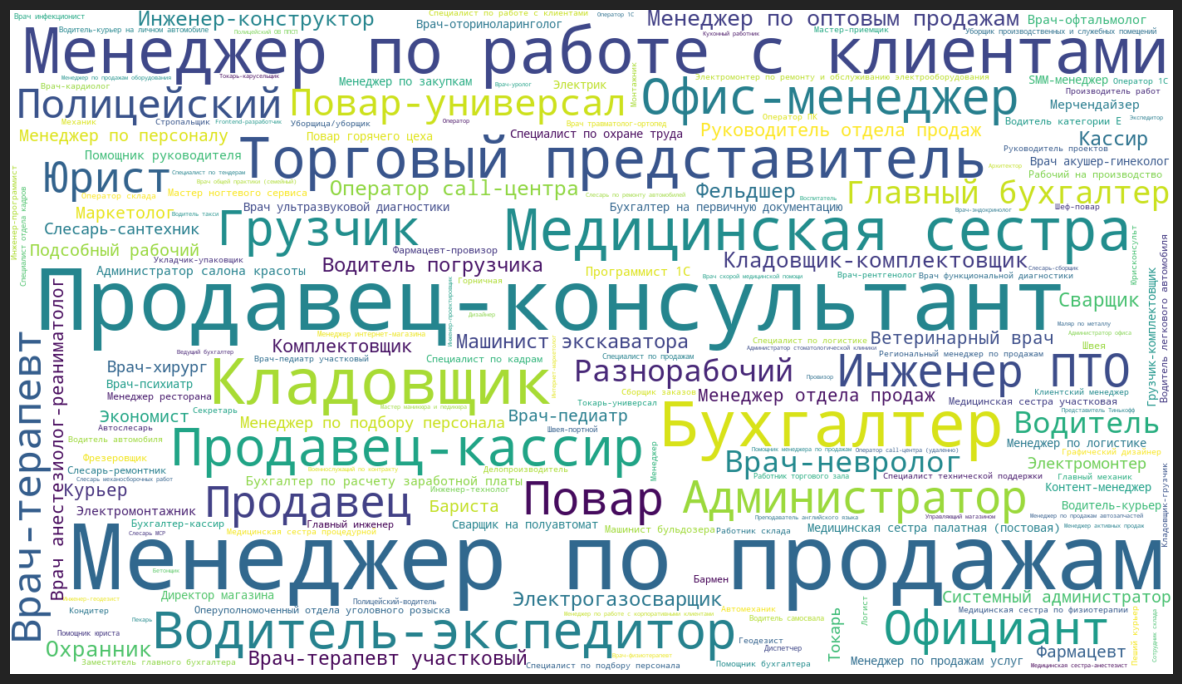

In [11]:
#!pip install wordcloud
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))

wordcloud = WordCloud(
    stopwords=stop_words, background_color='white', width=1400, height=800).generate_from_frequencies(df.name.value_counts())
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Бегло посмотрим на рпаспределение типов занятостии графика работы:

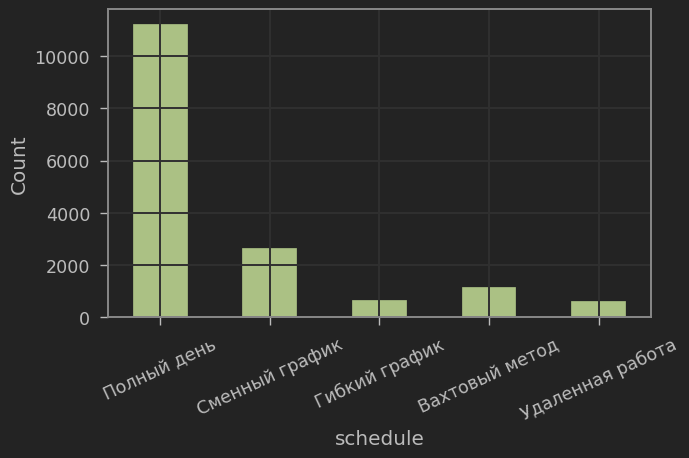

In [12]:
plt.figure(figsize=(7,4))
plt.xticks(rotation=25)
sns.histplot(df['schedule'], color='#DAF7A6', shrink=0.5);

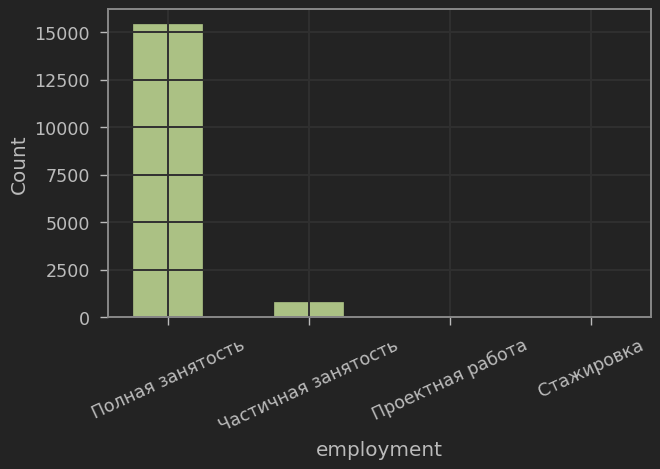

In [13]:
plt.figure(figsize=(7,4))
plt.xticks(rotation=25)
sns.histplot(df['employment'], color='#DAF7A6', shrink=0.5);

Вполне ожидаемо, абсолютно большая часть - полный день + полная занятость. \
Посмотрим на распределение целевой переменной - зарплаты:

In [14]:
df['salary'].describe()

count     16321.000000
mean      52841.960572
std       34350.867894
min          30.000000
25%       30000.000000
50%       45000.000000
75%       65000.000000
max      540000.000000
Name: salary, dtype: float64

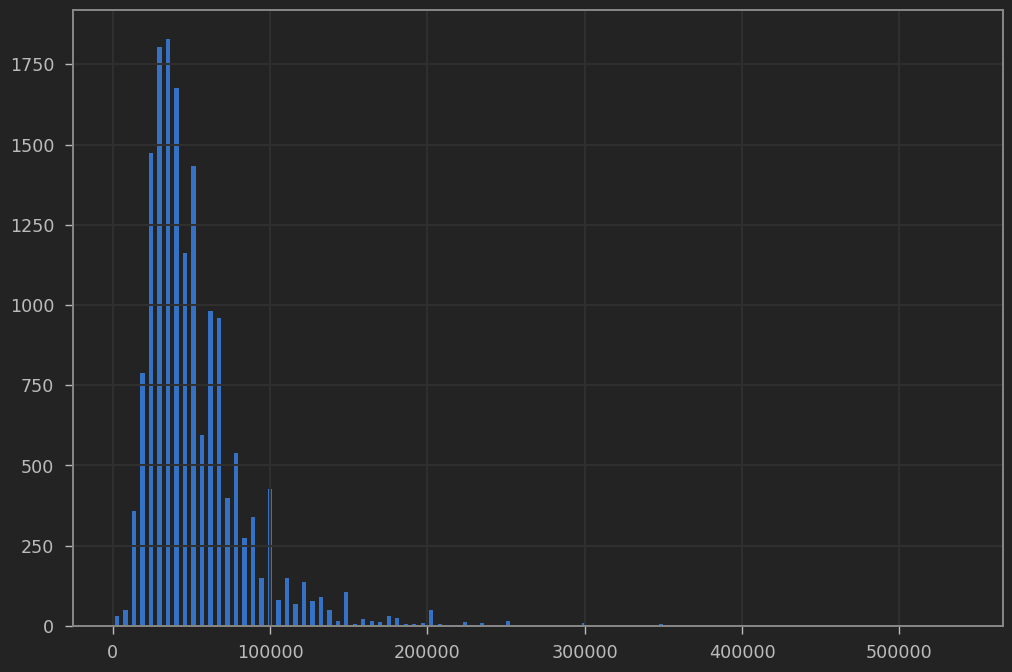

In [15]:
plt.hist(df.salary, bins = 100, rwidth=0.5);

Похоже на лог-нормальное распределение, попробуем отлогарифмировать:

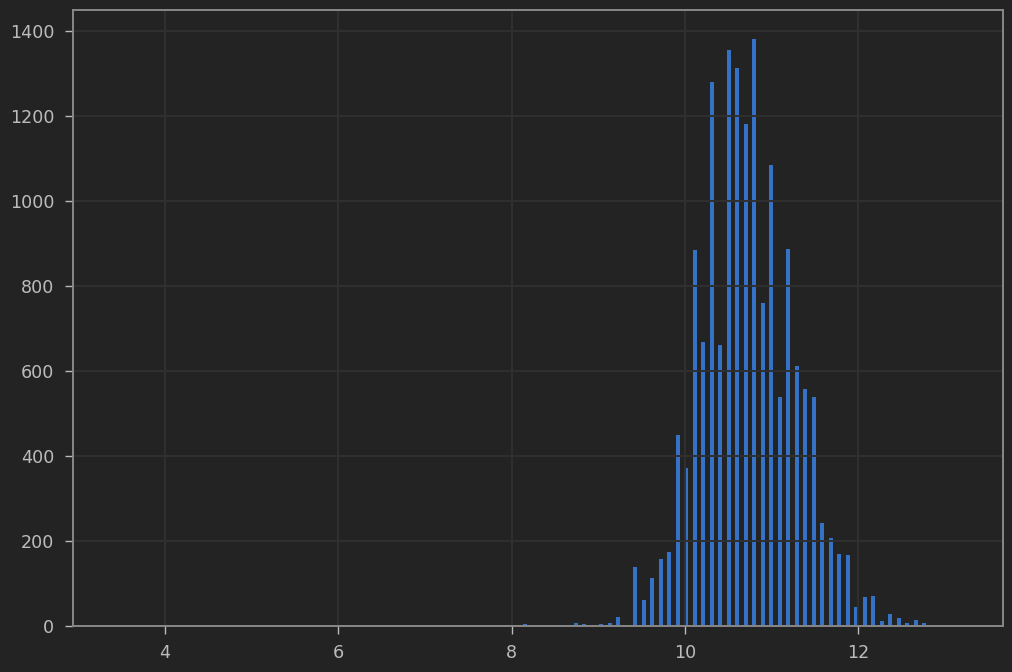

In [16]:
plt.hist(np.log(df.salary), bins = 100, rwidth=0.5);

В дальнейшем попробуем сравнить качество модели с использованием логарифмирования и без.
Посмотрим какие вакансии наиболее популярны:

А что там с совместным распределением зарплат по типу занятости опыту?

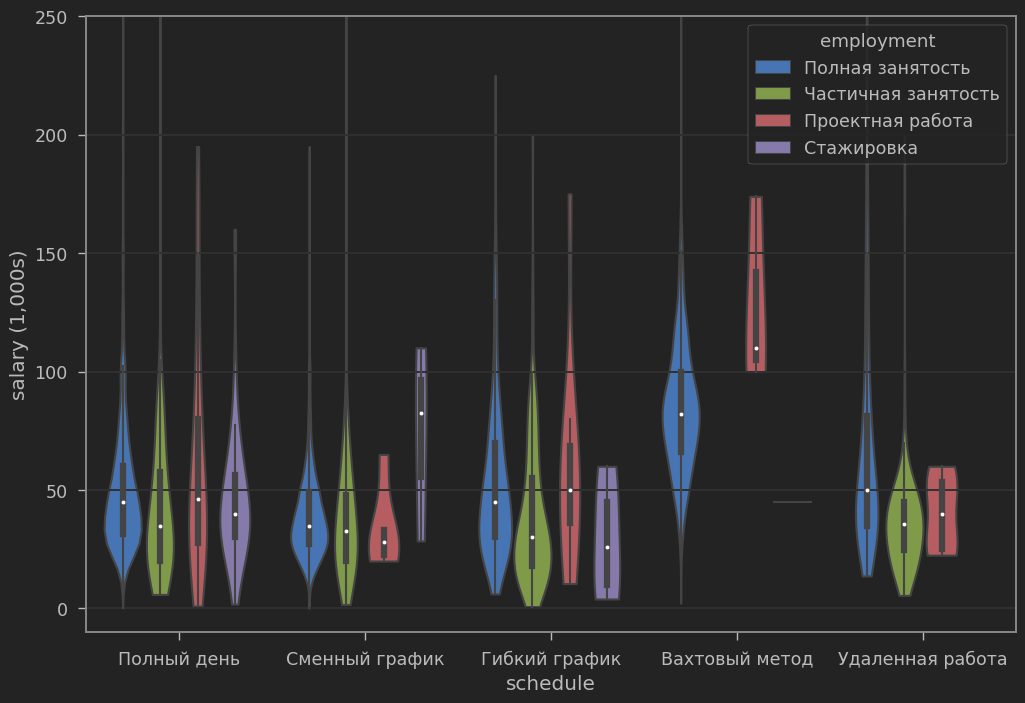

In [17]:
# cut=0 чтобы на графике отображались только днаные из датасета, без сглаживания,
# которое может визуально показать отрицательную зарплату.
# scale='area' чтобы нивелировать разницу в частоте видов занятости.
sns.violinplot(data=df, y=df['salary']/1000, x='schedule', hue='employment',
               scale='area', cut=0) 
plt.ylabel('salary (1,000s)')
plt.ylim(-10, 250); # отрезаем зарплты 250+, поскольку они являются выбросами,
                   # и визуально только помешают оценить взаимсвязи

Четкую зависимость установить трудно, разве что вахтовый метод выбивается в большую сторону, что вполне логично, перекодировать в цислительный не будем

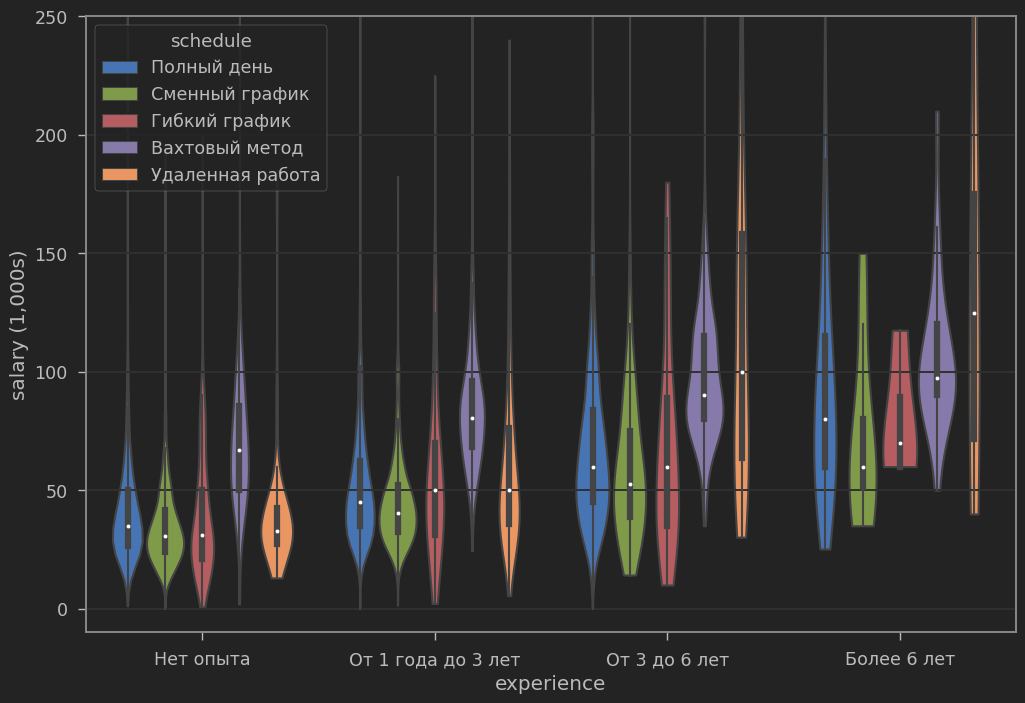

In [18]:
sns.violinplot(data=df, y=df['salary']/1000, x='experience', hue='schedule',
               order=df.experience.value_counts().keys(), scale='area', cut=0) 
plt.ylabel('salary (1,000s)')
plt.ylim(-10, 250);

Тут пару выводов выводов: \
1 - четко виден тренд, что зарплата растет в зависимости от требуемого опыта, поэтому будем перекодировать признак опыта на числительный 1-4, где 1 - "нет опыта", а 4 - "более 6 лет". \
2 - огромные выбросы в большую сторону, даже там где опыт не требуется, подозреваю что это вакансии связанные с продажами, с низким окладом, и "безграничными возможностями заработать миллиарды" как % от продаж. И небольшие (логично ограниченные нулем) выбросы в меньшую сторону.

#### Я не хочу удалять выбросы в большую сторону, так как это приведет к потере части информации, выбросы в меньшую сторону обусловлены почасовой или посменной оплатой, хочется исправить, но это крайне проблемматично, поскольку потребует ручных правок, если их не очень много, то оставлю как есть

In [19]:
df[df.salary < 10000].shape

(59, 7)

59 вакансий с зарплатой меньше 10 тыс, выборосы в меньшую оставляем как есть.
___

#### Предобработка текста:
Перед тем как преобразовывать текст в вектора методами вроде TFIDF / Word2Vec, его нужно подготовить, очистить от знаков препинания, лишних символов, стоп слов, привести слова к нормальной форме. \
Для очистки напишем несколько функций:


In [20]:
# создадим новый датафрейм, где будут очищенные данные:
df_p = pd.DataFrame() # p - processed

# Создадим функцию для замены признака опыта на количественный:
def conditions(x):
    if x == 'Нет опыта': return 1
    elif x == 'От 1 года до 3 лет': return 2
    elif x == 'От 3 до 6 лет': return 3
    else: return 4

conditions_vect = np.vectorize(conditions)

In [21]:
# мусорные, не несущие особого смысла слова, кандидаты на удаление,
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))

print('Примеры стоп слов:')
for i in range(3):
    print(list(stop_words)[i])
print(f'всего стоп слов: {len(stop_words)}')

Примеры стоп слов:
на
я
так
всего стоп слов: 151


In [22]:
import re

# функция для чистки текстов (описаний) от разного регистра, и всякого мусора
# вроде стопслов или не текстовых значений
def initial_processing(corpus):
    n = len(corpus)
    for i in range(n):
        corpus[i] = corpus[i].lower()
        corpus[i] = re.sub(r'[^а-яА-Яa-zA-Z0-9]', ' ', corpus[i])
        corpus[i] = [word for word in corpus[i].split() if word not in stop_words and len(word) > 1]
        corpus[i] = ' '.join(corpus[i])
    return corpus

In [23]:
# Для примера:
# текст описания ДО:
example_text = df['description'][0:2].copy()
example_text[0]

'Водитель-экспедитор категории В,С (а\\м ГАЗЕЛЬ тент, ГАЗЕЛЬ цельнометаллическая, ГАЗ фургон) Обязанности:  развоз товара по точкам в черте г.Владимира и области по графику, доставка товара в Москву, Иваново, Рязань, экспедирование, приемка-передача товара в точках, разгрузка товара в точках, материальная ответственность за транспортное средство, груз, товаросопроводительные документы, содержание подотчетного транспортного средства в технически исправном рабочем состоянии, мелкий текущий ремонт и техобслуживание    Требования:  наличие водительского удостоверения категории В и/или С, спокойствие, выносливость, достаточная подготовка, вежливость, опыт текущего ремонта и техобслуживания отечественных транспортных средств    Условия:  выплата заработка 2 раза в месяц отпуск два раза в год (осень-весна) по 14 календарных дней официальное трудоустройство и соцпакет '

In [24]:
# текст описания ПОСЛЕ:
a = initial_processing(example_text)
a[0]

'водитель экспедитор категории газель тент газель цельнометаллическая газ фургон обязанности развоз товара точкам черте владимира области графику доставка товара москву иваново рязань экспедирование приемка передача товара точках разгрузка товара точках материальная ответственность транспортное средство груз товаросопроводительные документы содержание подотчетного транспортного средства технически исправном рабочем состоянии мелкий текущий ремонт техобслуживание требования наличие водительского удостоверения категории спокойствие выносливость достаточная подготовка вежливость опыт текущего ремонта техобслуживания отечественных транспортных средств условия выплата заработка раза месяц отпуск раза год осень весна 14 календарных дней официальное трудоустройство соцпакет'

Будем использовать признаки:
 - название вакасии
 - описание вакансии
 - требуемый опыт
 - ключевые навыки

In [25]:
df_p['name'] = initial_processing(df['name'].copy())
df_p['description'] = initial_processing(df['description'].copy())
df_p['experience'] = conditions_vect(df['experience'])
df_p['key_skills'] = initial_processing(df['key_skills'].copy())

In [26]:
df_p.head(3)

,name,description,experience,key_skills
0,водитель экспедитор,водитель экспедитор категории газель тент газе...,3,
1,кладовщик комплектовщик оператор 1с,обязанности списывание материалов производство...,2,знание пк работа 1с работа команде складской у...
2,продавец магазина магнит кировский уса,крупнейшую федеральную сеть магазинов магнит т...,1,


In [27]:
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from tqdm import tqdm

morph = MorphAnalyzer()

# Принимаем слово, возвращаем нормальную форму,
# также используем кэширование для ускорения (много одинаковых итераций):
@lru_cache(maxsize=256)
def lemmatize_word(word):
    return morph.parse(word)[0].normal_form 

# Пробегаемся по корпусу, в каждом куске, пробегаемся по всем словам, передавая их в функцию выше
# и сохраняем преобразованные параграфы:
def lemmatize(corpus):
    n = len(corpus)
    with tqdm(total=n) as pbar:
        for i in range(n):
            corpus[i] = ' '.join([lemmatize_word(word) for word in corpus[i].split()])
            pbar.update(1)
    return corpus

In [28]:
df_p['name'] = lemmatize(df_p['name'].copy())
df_p['description'] = lemmatize(df_p['description'].copy())
df_p['key_skills'] = lemmatize(df_p['key_skills'].copy())

100%|███████████████████████████████████| 16321/16321 [00:03<00:00, 4968.06it/s]


In [32]:
df_p.head()

,name,description,experience,key_skills
0,водитель экспедитор,водитель экспедитор категория газель тент газе...,3,
1,кладовщик комплектовщик оператор 1с,обязанность списывание материал производство п...,2,знание пк работа 1с работа команда складской у...
2,продавец магазин магнит кировский уса,крупный федеральный сеть магазин магнит требов...,1,
3,администратор магазин тц spar,крупный федеральный сеть магазин мужской женск...,2,
4,мойщик посуда кулинария,обязанность уборка производственный площадь ку...,1,пользователь пк грамотный речь работа оргтехни...


In [33]:
from sklearn.model_selection import train_test_split
y = df['salary']
X_train, X_test, y_train, y_test = train_test_split(df_p, y, test_size=0.25, random_state=3)

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12240, 4), (12240,), (4081, 4), (4081,))

#### Baseline: TF-IDF векторизация описания вакансии с дефолтными параметрами + линейная регрессия со стохастическим градиентным спуском

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDRegressor

base_tfidf = TfidfVectorizer()
X_train_tfidf = base_tfidf.fit_transform(X_train['description'])

In [56]:
count = CountVectorizer(min_df=10)
X_count = count.fit(X_train['description'])

In [66]:
X_count_trans = count.transform(X_train['description'])

In [73]:
X_count_trans.shape

(12240, 6475)

In [84]:
len(X_count.vocabulary_)

6475

In [85]:
X_count_dense = pd.DataFrame(X_count_trans.todense())

In [87]:
%%time
reg = SGDRegressor(max_iter=1000, learning_rate='adaptive', penalty = 'l2', random_state=rng)
reg.fit(X_count_dense, y_train)

CPU times: user 1min 58s, sys: 120 ms, total: 1min 59s
Wall time: 1min 58s


/home/sergey/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDRegressor(learning_rate='adaptive', random_state=1337)

In [80]:
%%time
reg = SGDRegressor(max_iter=4000, learning_rate='adaptive', penalty = 'l2', random_state=rng)
reg.fit(X_train_tfidf, y_train)

CPU times: user 2.3 s, sys: 56 ms, total: 2.35 s
Wall time: 1.07 s


SGDRegressor(learning_rate='adaptive', max_iter=20000, random_state=1337)

In [88]:
X_test_count_trans = count.transform(X_test['description'])
pred = reg.predict(X_test_count_trans)
r2_score(y_test, pred)

-30399152967.24432

In [76]:
reg.n_iter_

4000

In [77]:
from sklearn.metrics import r2_score

In [78]:
X_test_tfidf = base_tfidf.transform(X_test['description'])
pred = reg.predict(X_test_tfidf)
r2_score(y_test, pred)

ValueError: X has 33366 features, but SGDRegressor is expecting 6475 features as input.

In [42]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg, X_train_tfidf, y_train,
                         scoring='r2', cv=10, verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    3.3s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.7s finished


In [43]:
scores

array([0.43461591, 0.45779109, 0.4518263 , 0.39483357, 0.43588573,
       0.42891185, 0.4347258 , 0.49146933, 0.45421624, 0.42737855])

In [58]:
scores

array([0.43461591, 0.45779109, 0.4518263 , 0.39483357, 0.43588573,
       0.42891185, 0.4347258 , 0.49146933, 0.45421624, 0.42737855])

[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   2.7s
[CV] END .................................................... total time=   3.0s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.0s
[CV] END .................................................... total time=   3.0s
[CV] END .................................................... total time=   4.7s
[CV] END .................................................... total time=   6.1s


In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [ ]:
pretrained_model = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
config = AutoConfig.from_pretrained(pretrained_model)
model = AutoModel.from_pretrained(pretrained_model, output_hidden_states=True)

In [ ]:
df_train['set'] = 'train'
df_test['set'] = 'test'
df = pd.concat([df_train, df_test])

In [ ]:
corpus = tokenizer((df_train.name+' '+df_train.description).tolist(),
                  add_special_tokens=True,
                  padding='max_length',
                  truncation='longest_first',
                  max_length=512,
                  return_attention_mask=True,
                  return_tensors='pt')

In [ ]:
input_ids = corpus['input_ids']
attention_mask = corpus['attention_mask']
input_ids = np.array(input_ids)
attention_mask = np.array(attention_mask)
labels = df_train.salary.to_numpy()